In [29]:
# Importing necessary libraries

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [30]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Paths to dataset folders
dataset_path = '/content/drive/MyDrive/ML_Project/Dataset'
categories = ['Bus', 'Car', 'motorcycle', 'Truck']

In [32]:
# Data Preprocessing
img_size = 128  # Standardizing image size
data = []
labels = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    class_index = categories.index(category)
    for img in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img)
            img = load_img(img_path, target_size=(img_size, img_size))
            img_array = img_to_array(img)
            data.append(img_array)
            labels.append(class_index)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

In [5]:
# Converting to numpy arrays
data = np.array(data) / 255.0  # Normalize pixel values
labels = np.array(labels)

In [6]:
# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# One-hot encoding labels
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the training data
datagen.fit(X_train)


In [33]:
# Transfer Learning with VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=15,  # Increase epochs if needed
                    validation_data=(X_val, y_val))

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.3057 - loss: 1.5013 - val_accuracy: 0.6000 - val_loss: 1.1828
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.4090 - loss: 1.2438 - val_accuracy: 0.7500 - val_loss: 0.9832
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5444 - loss: 1.0485 - val_accuracy: 0.7500 - val_loss: 0.8832
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7308 - loss: 0.8604 - val_accuracy: 0.8333 - val_loss: 0.7550
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7202 - loss: 0.7824 - val_accuracy: 0.7833 - val_loss: 0.7231
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7535 - loss: 0.7106 - val_accuracy: 0.8333 - val_loss: 0.6594
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7539 - loss: 0.6488 - val_accuracy: 0.8333 - val_loss: 0.6041
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7716 - loss: 0.6000 - val_accuracy: 0.8500 - val_loss: 0.5840

In [36]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7944 - loss: 0.6166
Test Accuracy: 81.67%


In [37]:
# Save the model
model.save('/mnt/data/your_id_vehicle_classification_model_vgg16.h5')

In [38]:
# Generating a classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=categories))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 448ms/step

Classification Report:
               precision    recall  f1-score   support

         Bus       0.88      0.74      0.80        19
         Car       0.86      0.86      0.86        14
  motorcycle       0.92      1.00      0.96        12
       Truck       0.65      0.73      0.69        15

    accuracy                           0.82        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.82      0.82      0.82        60



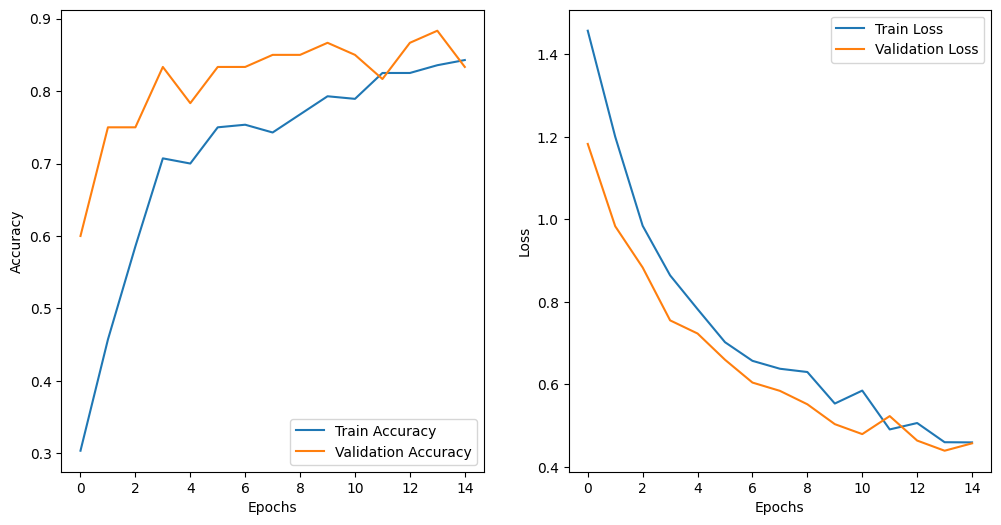

In [39]:
# Plotting training and validation accuracy/loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('/mnt/data/your_id_training_validation_plot.png')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


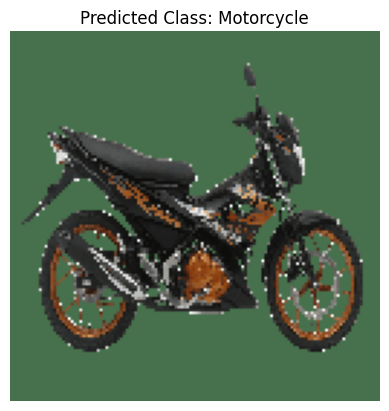

Prediction Scores: {'Bus': 0.00030299686, 'Car': 0.01684534, 'Motorcycle': 0.9816458, 'Truck': 0.0012059275}


In [44]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/mnt/data/your_id_vehicle_classification_model_vgg16.h5')

# Categories and image size
categories = ['Bus', 'Car', 'Motorcycle', 'Truck']
img_size = 128

# Function to classify a single image
def classify_image(image_path):
    img = load_img(image_path, target_size=(img_size, img_size))  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)  # Get predictions
    predicted_class = np.argmax(predictions, axis=1)  # Get the class with the highest probability
    return img, categories[predicted_class[0]], predictions[0]

# Test the function with an example image
image_path = '/content/drive/MyDrive/ML_Project/Dataset/motorcycle/Image_15.png'  # Replace with the path to your image
img, predicted_class, prediction_scores = classify_image(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f"Predicted Class: {predicted_class}")
plt.show()

# Print prediction scores
print(f"Prediction Scores: {dict(zip(categories, prediction_scores))}")
